<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

# Подготовка

In [1]:
#pip install WordCloud

In [2]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

In [3]:
if os.path.exists('/datasets/toxic_comments.csv'):
    df = pd.read_csv('/datasets/toxic_comments.csv', index_col=[0], parse_dates=[0])
else:
    df = pd.read_csv('toxic_comments.csv', index_col=[0], parse_dates=[0])

df

In [4]:
df.info()

В данных 159 тыс строк, незаполненных значений нет.

Подготовим данные: приведем текст к нижнему регистру, удалим знаки препинания, лемматизируем текст.

In [5]:
def clear_text(text):    
    text = text.lower() 
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    words_list = text.split()
    return " ".join(words_list)

df['text'] = df['text'].apply(clear_text)

In [6]:
lemmatizer = WordNetLemmatizer()
def lemmatize(text):
    word_list = nltk.word_tokenize(text)
    lemmatized_output = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return lemmatized_output

In [7]:
df['lemm_text'] = df['text'].apply(lemmatize)

In [8]:
df

Построим облако слов по всем комментариям, токсичным и нейтральным комментариям.

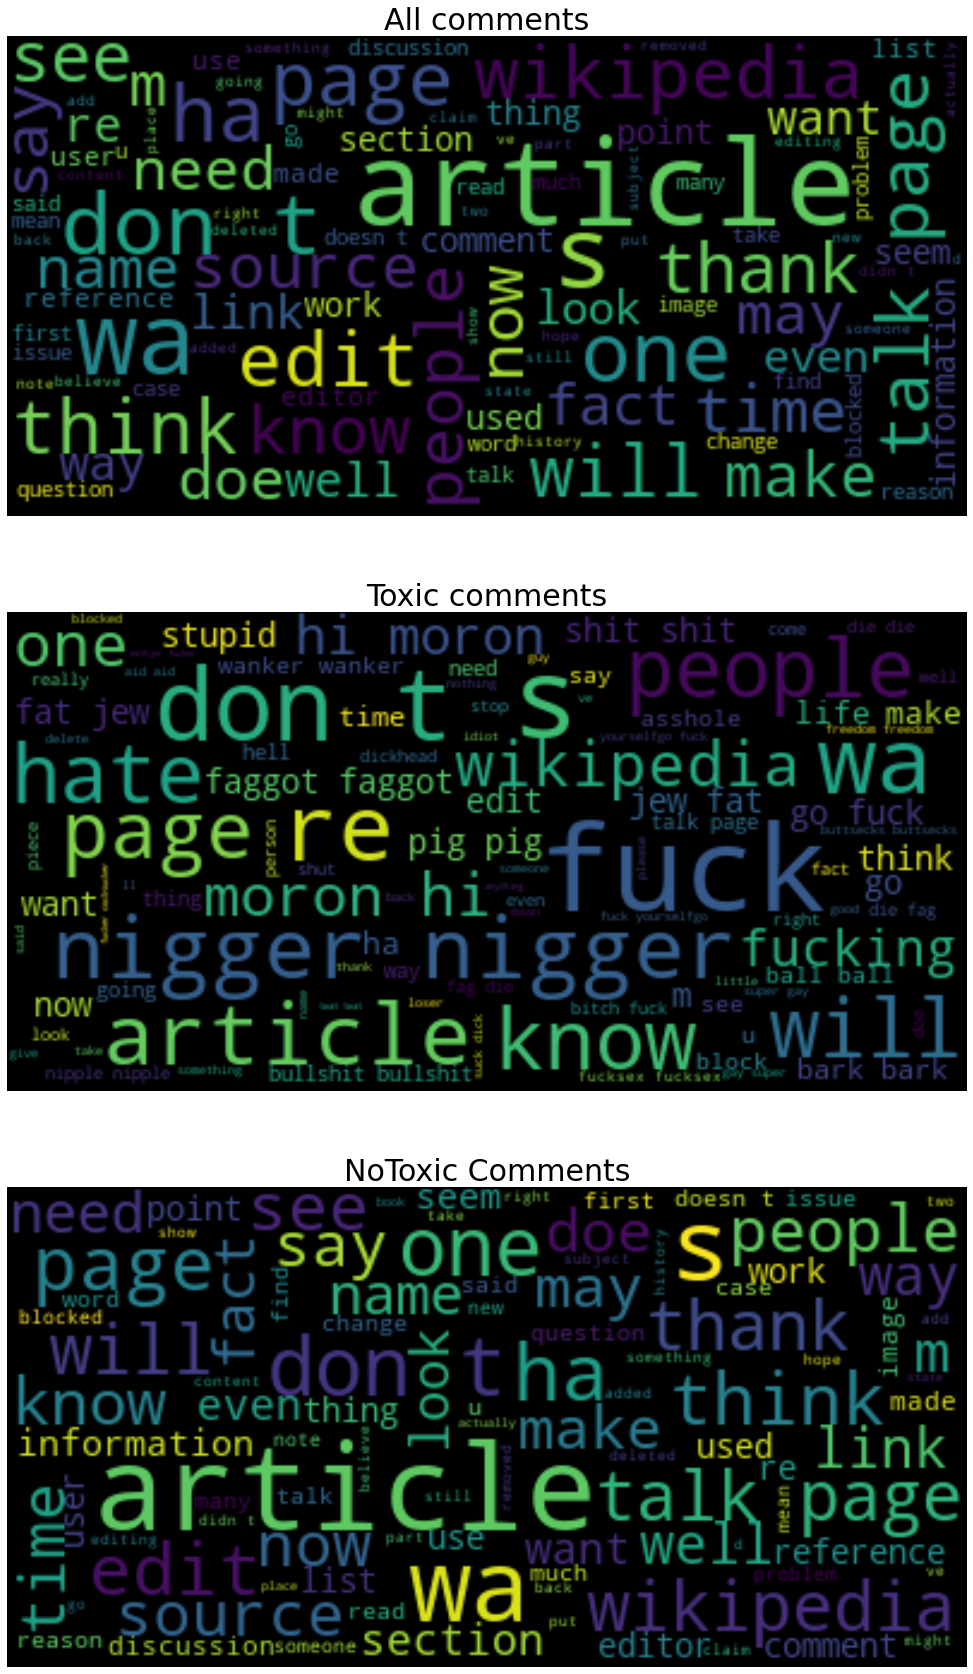

In [9]:
df_toxic = df[df['toxic']==1]
df_notoxic = df[df['toxic']==0]

all_comments = " ".join(review for review in df.lemm_text)
toxic_comments = " ".join(review for review in df_toxic.lemm_text)
notoxic_comments = " ".join(review for review in df_notoxic.lemm_text)

fig, ax = plt.subplots(3, 1, figsize  = (30,30))
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(all_comments)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(toxic_comments)
wordcloud_notoxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(notoxic_comments)

ax[0].imshow(wordcloud_all, interpolation='bilinear')
ax[0].set_title('All comments', fontsize=30)
ax[0].axis('off')
ax[1].imshow(wordcloud_toxic, interpolation='bilinear')
ax[1].set_title('Toxic comments',fontsize=30)
ax[1].axis('off')
ax[2].imshow(wordcloud_notoxic, interpolation='bilinear')
ax[2].set_title('NoToxic Comments',fontsize=30)
ax[2].axis('off')

В токсичных комментариях встречается много обсценной лексики.

Данные не сбалансированы по признаку toxic:

In [10]:
print(df['toxic'].value_counts()[0])
print(df['toxic'].value_counts()[1])

Вычислим соотношение значений целевого признака.

In [11]:
class_ratio = df['toxic'].value_counts()[0] / df['toxic'].value_counts()[1]
class_ratio

Поделим данные на признаки и целевой признак и выборки.

In [12]:
features = df.drop(['text', 'toxic'], axis=1)
target = df['toxic']

features_train, features_test, target_train, target_test = train_test_split(
                                            features, target, test_size=0.25, stratify=target)

Удалим стоп-слова.

In [13]:
stop_words = set(nltk_stopwords.words('english')) 

features_train_corpus = features_train['lemm_text'].values
features_test_corpus = features_test['lemm_text'].values

count_vect = TfidfVectorizer(stop_words=stop_words) 
count_vect.fit(features_train_corpus)
features_train = count_vect.transform(features_train_corpus)
features_test = count_vect.transform(features_test_corpus)

In [14]:
print(features_train.shape)
print(features_test.shape)

В данных 159 тыс строк, незаполненных значений нет. Данные не сбалансированы по целевому признаку, это надо учитывать при обучении моделей и также это учтено при разбивке на выборки.
Тексты комментариев были очищены от знаков препинаний и лемматизированы. Также были подготовлены признаки tf-idf для дальнейшего обучения моделей.

# Обучение

Обучим две модели:
* логистическую регресиию
* случайный лес

## Логистическая регрессия

Поскольку классы не сбалансированы, попробуем два способа борьбы с этим.

In [15]:
%%time

param_grid = {'solver':['lbfgs', 'liblinear'],
                   'max_iter': [1000]}

lr = LogisticRegression(class_weight='balanced')

# инициализируем GridSearchCV
grid_search = GridSearchCV(estimator = lr, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0,                           
                           scoring = 'f1',
                          )
grid_search.fit(features_train, target_train)

In [32]:
grid_search.best_params_

In [33]:
grid_search.best_score_

In [16]:
%%time

from sklearn.pipeline import Pipeline 

x_train, x_test, y_train, y_test = train_test_split(
                                            features, target, test_size=0.25, stratify=target)
pipe_lr = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression(random_state=42))])

grid_params_lr = [{'tfidf__stop_words': [stop_words],
                   'clf__max_iter': [1000],
                    'clf__solver': ['lbfgs', 'liblinear'],
                    'clf__class_weight':['balanced']}] 

# print(pipe_lr.get_params().keys())

grid_search_pipeline = GridSearchCV(estimator=pipe_lr,
            param_grid=grid_params_lr,
            scoring='f1',
            cv=5) 

grid_search_pipeline.fit(x_train['lemm_text'], y_train)

In [17]:
grid_search_pipeline.best_params_

In [18]:
grid_search_pipeline.best_score_

In [19]:
%%time

dict_classes={0:1, 1:class_ratio}

param_grid = {'solver':['lbfgs', 'liblinear'],
                'max_iter': [1000],
                'class_weight':[dict_classes]}

lr_01 = LogisticRegression()

# инициализируем GridSearchCV
grid_search_01 = GridSearchCV(estimator = lr_01, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0,                           
                           scoring = 'f1',
                          )
grid_search_01.fit(features_train, target_train)

In [20]:
grid_search_01.best_params_

In [21]:
grid_search_01.best_score_

Та же модель в pipeline.

In [31]:
%%time

dict_classes={0:1, 1:class_ratio}

pipe_lr_01 = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LogisticRegression(random_state=42))])

grid_params_lr_01 = [{'tfidf__stop_words': [stop_words],
                   'clf__max_iter': [1000],
                    'clf__solver': ['lbfgs', 'liblinear'],
                    'clf__class_weight':[dict_classes]}] 

# print(pipe_lr.get_params().keys())

grid_search_pipeline_01 = GridSearchCV(estimator=pipe_lr_01,
            param_grid=grid_params_lr_01,
            scoring='f1',
            cv=5) 

grid_search_pipeline_01.fit(x_train['lemm_text'], y_train)

In [23]:
grid_search_pipeline_01.best_score_

Таким образом, указание соотношения классов отрабатывает чуть лучше и значение метрики 0,753 соответствует заданному.

## Cлучайный лес

Попробуем те же приемы на модели случайного леса.

In [24]:
%%time

dict_classes={0:1, 1:class_ratio}

param_grid = {'n_estimators':[1, 5, 10],
                #'max_depth': [10, 25, 30],
                'class_weight':[dict_classes]}

rfc = RandomForestClassifier(random_state=12345)

# инициализируем GridSearchCV
grid_search_rfc = GridSearchCV(estimator = rfc, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0,                           
                           scoring = 'f1',
                          )
grid_search_rfc.fit(features_train, target_train)

In [25]:
grid_search_01.best_params_

In [26]:
grid_search_rfc.best_score_

In [27]:
%%time


param_grid = {'n_estimators':[1, 5, 10]
#               ,
#                 'max_depth': [10, 25, 30]
             }

rfc_01 = RandomForestClassifier(random_state=12345, class_weight='balanced')

# инициализируем GridSearchCV
grid_search_rfc_01 = GridSearchCV(estimator = rfc_01, 
                           param_grid = param_grid, 
                           cv = 5,
                           n_jobs = -1, 
                           verbose = 0,                           
                           scoring = 'f1',
                          )
grid_search_rfc_01.fit(features_train, target_train)

In [28]:
grid_search_rfc_01.best_score_

Значение f1-меры 0,60 значительно ниже 0,75. Разные параметры для борьбы с дисбалансом дали практически одинаковый результат.

## Проверка на test

Проверим модель логистической регрессии на тестовых данных.

In [29]:
predictions = grid_search_01.best_estimator_.predict(features_test)

print(f1_score(predictions, target_test))

Проверка модели из pipeline.

In [30]:
predictions_01 = grid_search_pipeline_01.best_estimator_.predict(x_test['lemm_text'])

print(f1_score(predictions_01, y_test))

Метрика на тестовых данных не ухудшилась, даже немного улучшилась.

## Выводы

Для нового сервиса интернет-магазина «Викишоп», позволяющего дополнять описания товаров, была разработана модель поиска токсичных комментариев. Этот инструмент будет искать токсичные комментарии и отправлять их на модерацию.

В нашем распоряжении набор данных с разметкой о токсичности правок. В данных 159 тыс строк, незаполненных значений нет. Данные не сбалансированы по целевому признаку, это надо учитывать при обучении моделей и также это учтено при разбивке на выборки. Тексты комментариев были очищены от знаков препинаний и лемматизированы. Также были подготовлены признаки tf-idf для дальнейшего обучения моделей.

Было изучено две модели с разным подходом к балансировке классов:
* логистическая регрессия
* случайный лес.

Случайный лес работает дольше и выдает значение метрики хуже, чем логистическая регрессия.

На тестовых данных значение метрики для логистической регрессии также превышает заданное: 0,76 против 0,75 заданных. 